In [1]:
# !pip install opendatasets --quiet
# import opendatasets as od
# od.download('https://www.kaggle.com/datasets/marquis03/bean-leaf-lesions-classification')

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader , Dataset
from torchvision import models
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# /kaggle/input/bean-leaf-lesions-classification/val/healthy/healthy_val.25.jpg

In [41]:
train_df = pd.read_csv('/kaggle/input/bean-leaf-lesions-classification/train.csv')
val_df = pd.read_csv('/kaggle/input/bean-leaf-lesions-classification/val.csv')

train_df['image:FILE'] = '/kaggle/input/bean-leaf-lesions-classification/' + train_df['image:FILE']
val_df['image:FILE'] = '/kaggle/input/bean-leaf-lesions-classification/' + val_df['image:FILE']

train_df.head()

,image:FILE,category
0,/kaggle/input/bean-leaf-lesions-classification...,0
1,/kaggle/input/bean-leaf-lesions-classification...,0
2,/kaggle/input/bean-leaf-lesions-classification...,0
3,/kaggle/input/bean-leaf-lesions-classification...,0
4,/kaggle/input/bean-leaf-lesions-classification...,0


In [5]:
print(train_df.shape)
print(val_df.shape)
train_df['category'].unique()

(1034, 2)
(133, 2)


array([0, 1, 2])

In [6]:
print(train_df['category'].value_counts())

category
2    348
1    345
0    341
Name: count, dtype: int64


In [7]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [43]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(dataframe['category']).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.labels[idx]
    image = Image.open(image_path)

    if self.transform:
      image = (self.transform(image)/255).to(device)

    return image,label

In [44]:
train_dataset = CustomImageDataset(dataframe=train_df,transform=transform)
val_dataset = CustomImageDataset(dataframe=val_df,transform=transform)

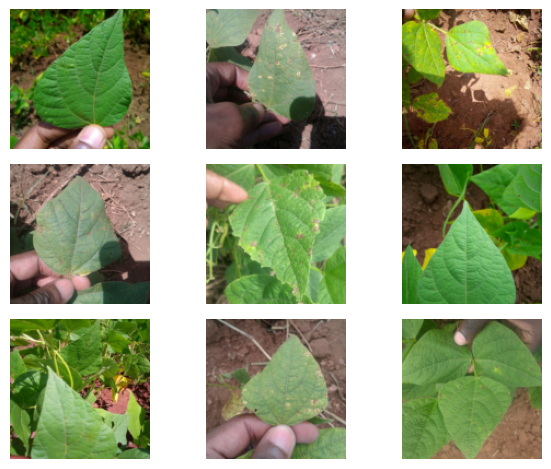

In [10]:
n_rows = 3
n_cols = 3
f,axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = train_dataset[np.random.randint(0,train_dataset.__len__())][0].cpu()
    axarr[row,col].imshow((image*255.0).squeeze().permute(1,2,0))
    axarr[row,col].axis('off')

plt.tight_layout()
plt.show()


In [11]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

In [50]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [33]:
googlenet_model = models.googlenet(weights='DEFAULT')

In [34]:
for param in googlenet_model.parameters():
  param.requires_grad = True

In [35]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [36]:
num_class = len(train_df['category'].unique())
num_class

3

In [37]:
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features,num_class)
googlenet_model.fc

Linear(in_features=1024, out_features=3, bias=True)

In [38]:
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(),lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0
  total_acc_train = 0

  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_fun(outputs,labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
  print(f"Epoch : {epoch+1}/{EPOCHS} , Train_Loss : {round(total_loss_train/1000,4)} , Train_Accuracy : {round(total_acc_train/train_dataset.__len__()*100,4)}")

Epoch : 1/15 , Train_Loss : 0.2446 , Train_Accuracy : 56.0928
Epoch : 2/15 , Train_Loss : 0.2183 , Train_Accuracy : 61.7021
Epoch : 3/15 , Train_Loss : 0.1797 , Train_Accuracy : 73.3075
Epoch : 4/15 , Train_Loss : 0.1919 , Train_Accuracy : 67.795
Epoch : 5/15 , Train_Loss : 0.1749 , Train_Accuracy : 73.0174
Epoch : 6/15 , Train_Loss : 0.1665 , Train_Accuracy : 74.5648
Epoch : 7/15 , Train_Loss : 0.1463 , Train_Accuracy : 76.8859
Epoch : 8/15 , Train_Loss : 0.1368 , Train_Accuracy : 80.0774
Epoch : 9/15 , Train_Loss : 0.1362 , Train_Accuracy : 78.8201
Epoch : 10/15 , Train_Loss : 0.1393 , Train_Accuracy : 78.2398
Epoch : 11/15 , Train_Loss : 0.1121 , Train_Accuracy : 84.1393
Epoch : 12/15 , Train_Loss : 0.0983 , Train_Accuracy : 85.6867
Epoch : 13/15 , Train_Loss : 0.1118 , Train_Accuracy : 84.236
Epoch : 14/15 , Train_Loss : 0.102 , Train_Accuracy : 84.7195
Epoch : 15/15 , Train_Loss : 0.1129 , Train_Accuracy : 85.2998


In [52]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for input,labels in val_loader:
        prediction = googlenet_model(input)

        acc = (torch.argmax(prediction,axis=1)==labels).sum().item()
        total_acc_test += acc

In [53]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

84.96


In [59]:
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
pred = []
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for input,labels in val_loader:
        prediction = googlenet_model(input)

        acc = (torch.argmax(prediction,axis=1)==labels).sum().item()
        total_acc_test += acc

        pred_batch = torch.argmax(prediction, dim=1)  # คำตอบของแต่ละ sample ใน batch
        pred.extend(pred_batch.cpu().tolist())        # แปลงเป็น list และเก็บไว้ใน pred

print(pred)


[0, 0, 2, 2, 0, 0, 2, 1, 0, 1, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2]


In [61]:
import pandas as pd

submission = pd.DataFrame({
    'image_id': val_df['image:FILE'],   # เช่น ['img_001.jpg', 'img_002.jpg', ...]
    'label': pred            # คำทำนายจากโมเดล
})

submission.to_csv('submission.csv', index=False)


In [64]:
val_df.head(100)

,image:FILE,category
0,/kaggle/input/bean-leaf-lesions-classification...,0
1,/kaggle/input/bean-leaf-lesions-classification...,0
2,/kaggle/input/bean-leaf-lesions-classification...,0
3,/kaggle/input/bean-leaf-lesions-classification...,0
4,/kaggle/input/bean-leaf-lesions-classification...,0
...,...,...
95,/kaggle/input/bean-leaf-lesions-classification...,2
96,/kaggle/input/bean-leaf-lesions-classification...,2
97,/kaggle/input/bean-leaf-lesions-classification...,2
98,/kaggle/input/bean-leaf-lesions-classification...,2


In [63]:
submission

,image_id,label
0,/kaggle/input/bean-leaf-lesions-classification...,0
1,/kaggle/input/bean-leaf-lesions-classification...,0
2,/kaggle/input/bean-leaf-lesions-classification...,2
3,/kaggle/input/bean-leaf-lesions-classification...,2
4,/kaggle/input/bean-leaf-lesions-classification...,0
...,...,...
128,/kaggle/input/bean-leaf-lesions-classification...,2
129,/kaggle/input/bean-leaf-lesions-classification...,2
130,/kaggle/input/bean-leaf-lesions-classification...,1
131,/kaggle/input/bean-leaf-lesions-classification...,2


## Transfer Learning

In [22]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = False

googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features,num_class)
googlenet_model.fc.requires_grad = True

googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [23]:
loss_fun = nn.CrossEntropyLoss()
optimizer = Adam(googlenet_model.parameters(),lr=LR)

total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_loss_train = 0
  total_acc_train = 0

  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = loss_fun(outputs,labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs,axis=1)==labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100,4))
  print(f"Epoch : {epoch+1}/{EPOCHS} , Train_Loss : {round(total_loss_train/1000,4)} , Train_Accuracy : {round(total_acc_train/train_dataset.__len__()*100,4)}")

Epoch : 1/15 , Train_Loss : 0.262 , Train_Accuracy : 47.6789
Epoch : 2/15 , Train_Loss : 0.2437 , Train_Accuracy : 56.383
Epoch : 3/15 , Train_Loss : 0.2346 , Train_Accuracy : 55.9961
Epoch : 4/15 , Train_Loss : 0.2286 , Train_Accuracy : 61.1219
Epoch : 5/15 , Train_Loss : 0.2279 , Train_Accuracy : 58.1238
Epoch : 6/15 , Train_Loss : 0.219 , Train_Accuracy : 62.3791
Epoch : 7/15 , Train_Loss : 0.2227 , Train_Accuracy : 62.1857
Epoch : 8/15 , Train_Loss : 0.2192 , Train_Accuracy : 62.089
Epoch : 9/15 , Train_Loss : 0.2245 , Train_Accuracy : 60.5416
Epoch : 10/15 , Train_Loss : 0.2118 , Train_Accuracy : 61.8956
Epoch : 11/15 , Train_Loss : 0.2216 , Train_Accuracy : 61.2186
Epoch : 12/15 , Train_Loss : 0.2126 , Train_Accuracy : 64.0232
Epoch : 13/15 , Train_Loss : 0.2198 , Train_Accuracy : 63.4429
Epoch : 14/15 , Train_Loss : 0.2202 , Train_Accuracy : 62.089
Epoch : 15/15 , Train_Loss : 0.2178 , Train_Accuracy : 62.3791


In [24]:
pred = []
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0

    for input,labels in val_loader:
        prediction = googlenet_model(input)

        acc = (torch.argmax(prediction,axis=1)==labels).sum().item()
        total_acc_test += acc

        pred_batch = torch.argmax(prediction, dim=1)  # คำตอบของแต่ละ sample ใน batch
        pred.extend(pred_batch.cpu().tolist())        # แปลงเป็น list และเก็บไว้ใน pred

print(pred)


[2, 0, 2, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 1, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 1, 2, 2, 0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 2, 1, 1, 2, 0, 2, 2, 1, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 0, 2, 1]


In [25]:
print(round(total_acc_test/val_dataset.__len__()*100,2))

34.59


In [26]:
val_df

,image:FILE,category
0,/kaggle/input/bean-leaf-lesions-classification...,0
1,/kaggle/input/bean-leaf-lesions-classification...,0
2,/kaggle/input/bean-leaf-lesions-classification...,0
3,/kaggle/input/bean-leaf-lesions-classification...,0
4,/kaggle/input/bean-leaf-lesions-classification...,0
...,...,...
128,/kaggle/input/bean-leaf-lesions-classification...,2
129,/kaggle/input/bean-leaf-lesions-classification...,2
130,/kaggle/input/bean-leaf-lesions-classification...,2
131,/kaggle/input/bean-leaf-lesions-classification...,2


In [27]:
# /kaggle/input/bean-leaf-lesions-classification/val/healthy/healthy_val.25.jpg

val_df['image:FILE'] = val_df['image:FILE'].apply(
    lambda x: os.path.splitext(os.path.basename(x))[0]
)
val_df

,image:FILE,category
0,healthy_val.25,0
1,healthy_val.32,0
2,healthy_val.3,0
3,healthy_val.16,0
4,healthy_val.10,0
...,...,...
128,bean_rust_val.43,2
129,bean_rust_val.17,2
130,bean_rust_val.38,2
131,bean_rust_val.16,2


In [28]:
len(pred)

133

In [29]:
import pandas as pd

submission = pd.DataFrame({
    'image_id': val_df['image:FILE'],   # เช่น ['img_001.jpg', 'img_002.jpg', ...]
    'label': pred            # คำทำนายจากโมเดล
})

submission.to_csv('submission.csv', index=False)


In [30]:
submission

,image_id,label
0,healthy_val.25,2
1,healthy_val.32,0
2,healthy_val.3,2
3,healthy_val.16,1
4,healthy_val.10,0
...,...,...
128,bean_rust_val.43,2
129,bean_rust_val.17,2
130,bean_rust_val.38,0
131,bean_rust_val.16,2
